# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Aaron Studer</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: Die Daten stehen uns zwar für Forschungs- und Bildungszwecke zur Verfügung, aber wir dürfen die Daten **nicht** an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio.v3 as imageio
import numpy as np
import glob

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Get all the names of the files
names = [f[-17:-4] for f in files]

print(images.shape)

(7, 256, 170)


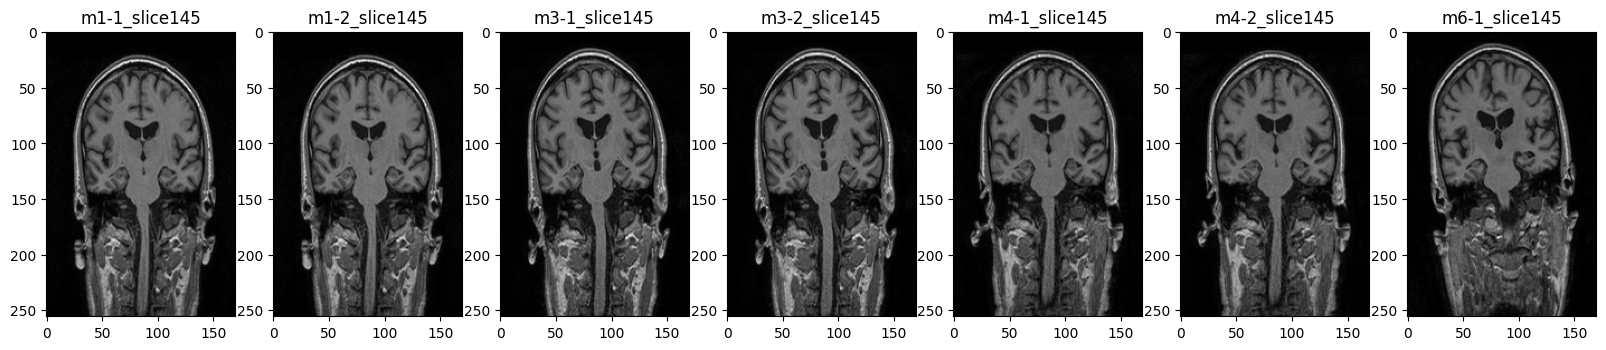

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [4]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


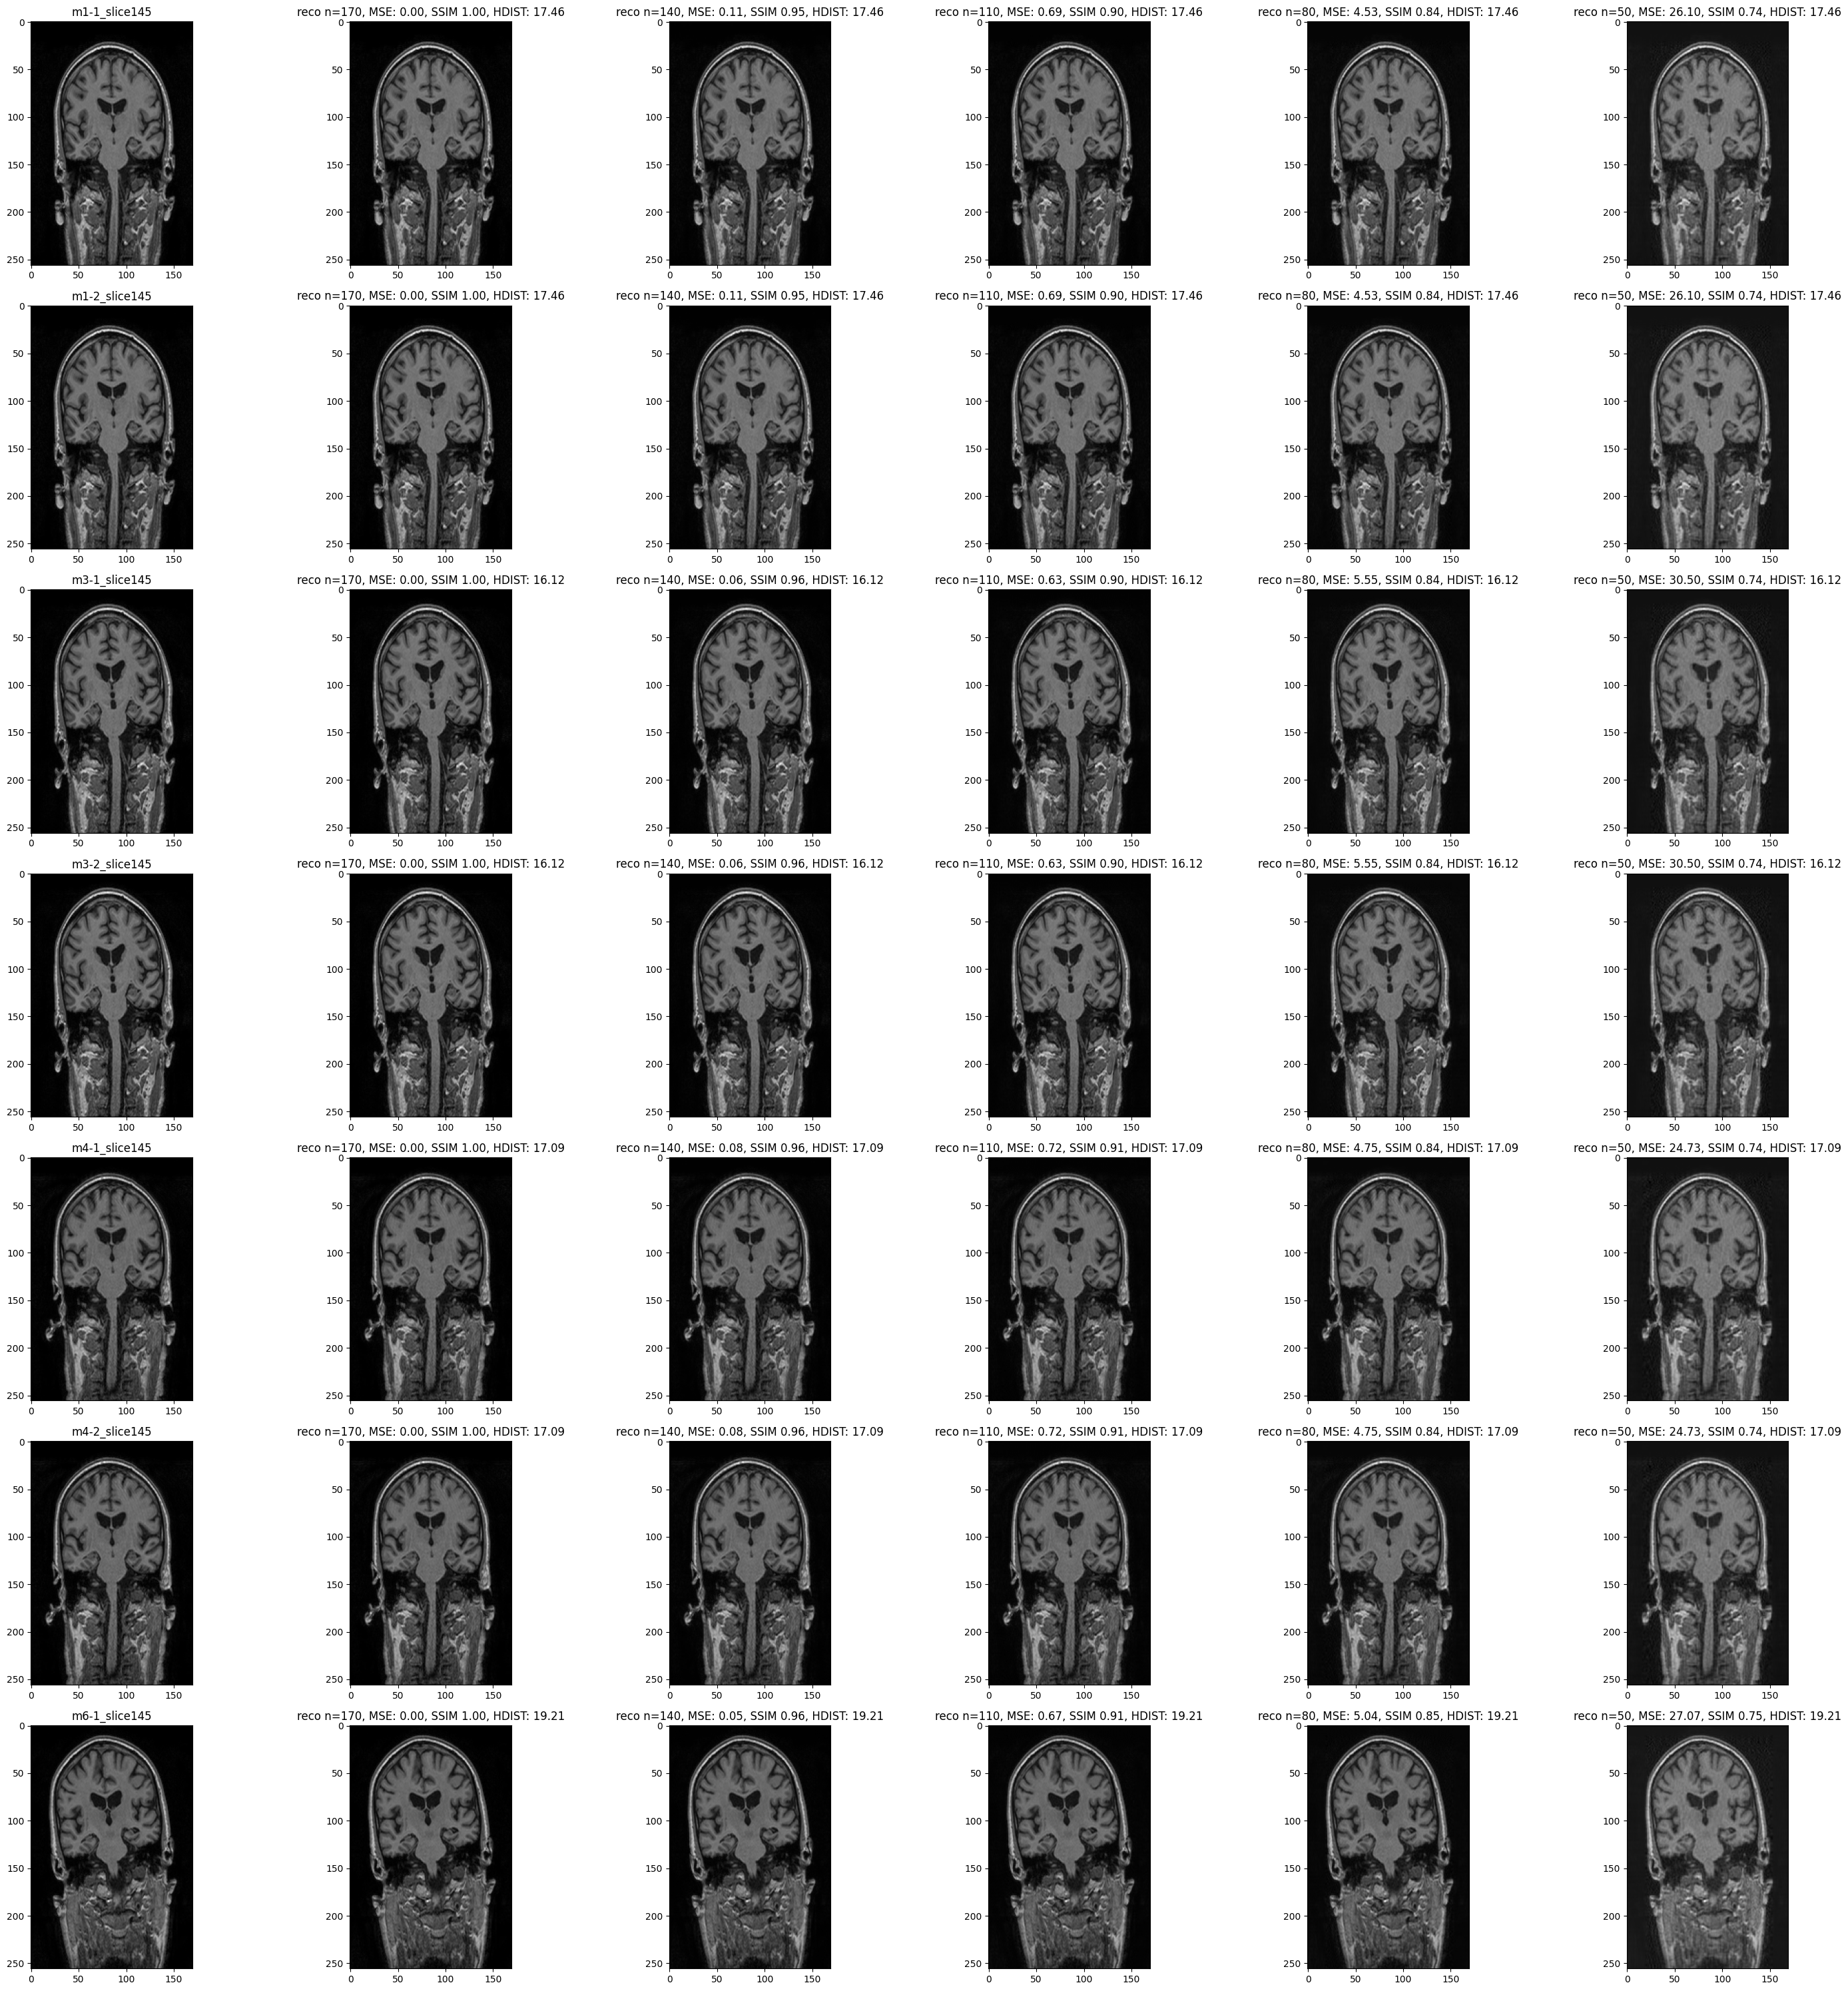

In [5]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im - im.min() / im.max() - im.min()  # normalize image
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
plt.tight_layout()


### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [6]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [7]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    
    # Implement formula directly with 3 loops
    for i in range(m):
        for j in range(n):
            for r in range(k):
                reco[i,j] += u[i,r] * s[r] * vt[r,j]

    return reco

In [8]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    
    # Use 2 loops by vectorizing the inner sum
    for i in range(m):
        for j in range(n):
            reco[i,j] = np.sum(u[i,:k] * s[:k] * vt[:k,j])
    

    return reco

In [9]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    
    # Use 1 loop by vectorizing over rows/columns
    for r in range(k):
        reco += np.outer(u[:,r] * s[r], vt[r,:])

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [10]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    # Use only first k components
    uk = u[:,:k]
    sk = s[:k]
    vtk = vt[:k,:]
    
    # Einstein summation: i refers to rows (m), j to columns (n), r to components (k)
    # Formula: sum_r(U_ir * s_r * V_rj)
    return np.einsum('ir,r,rj->ij', uk, sk, vtk)

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [11]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    # Slice first k components
    uk = u[:,:k]         # Shape: (m,k)
    sk = s[:k]          # Shape: (k,)
    vtk = vt[:k,:]      # Shape: (k,n)
    
    # Reshape s for broadcasting: (k,) -> (k,1)
    sk_reshaped = sk.reshape(-1, 1)
    
    # Broadcasting steps:
    # 1. Multiply s with V^T: (k,1) * (k,n) -> (k,n)
    sv = sk_reshaped * vtk
    # 2. Matrix multiply U with (sV): (m,k) @ (k,n) -> (m,n)
    return uk @ sv

In [12]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    # Slice first k components
    uk = u[:,:k]         # Shape: (m,k)
    sk = s[:k]          # Shape: (k,)
    vtk = vt[:k,:]      # Shape: (k,n)
    
    # Reshape arrays for 3D broadcasting:
    # uk: (m,k,1)
    # sk: (k,1)
    # vtk: (k,n)
    reshaped_u = uk.reshape(uk.shape[0], k, 1)
    reshaped_s = sk.reshape(k, 1)
    
    # Broadcasting multiplication and sum over k dimension
    return np.sum(reshaped_u * reshaped_s * vtk, axis=1)

#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

def benchmark_implementations(image, k_values, num_trials=3):
    """
    Benchmark different SVD reconstruction implementations for both timing and accuracy.
    
    Args:
        image: Input image array
        k_values: List of k components to test
        num_trials: Number of trials for each timing test
        
    Returns:
        tuple: (timing results dict, accuracy results dict)
    """
    # Get SVD components
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    
    implementations = [
        ('3 Loops', reconstruct_svd_for_loops3),
        ('2 Loops', reconstruct_svd_for_loops2),
        ('1 Loop', reconstruct_svd_for_loops1),
        ('Einsum', reconstruct_svd_einsum1),
        ('Broadcast 1', reconstruct_svd_broadcast1),
        ('Broadcast 2', reconstruct_svd_broadcast2)
    ]
    
    # Store results
    times = {name: [] for name, _ in implementations}
    accuracies = {name: [] for name, _ in implementations}
    
    # Use 3 Loops as baseline for accuracy comparison
    baseline_func = reconstruct_svd_for_loops3
    
    for k in k_values:
        print(f"\nTesting k={k}")
        # Get baseline reconstruction
        baseline_reco = baseline_func(u, s, vt, k)
        
        for name, func in implementations:
            # Timing trials
            trials = []
            for _ in range(num_trials):
                start = time()
                reco = func(u, s, vt, k)
                trials.append(time() - start)
            
            # Store average time
            avg_time = np.mean(trials)
            times[name].append(avg_time)
            
            # Calculate accuracy (max absolute difference from baseline)
            max_diff = np.max(np.abs(reco - baseline_reco))
            accuracies[name].append(max_diff)
            
            print(f"{name}: {avg_time:.4f} seconds, max diff: {max_diff:.2e}")
    
    return times, accuracies
    
def plot_comparison(times, accuracies, k_values):
    """
    Create three plots: seconds, milliseconds, and accuracy comparison.
    """
    colors = sns.color_palette('husl', n_colors=len(times))
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot seconds (0-1s)
    for (name, measurements), color in zip(times.items(), colors):
        clipped_times = np.clip(measurements, 0, 1)
        ax1.plot(k_values, clipped_times, 'o-', label=name, color=color)
    
    ax1.set_xlabel('Number of Components (k)')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Reconstruction Time (seconds)')
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylim(0, 5)
    
    # Plot milliseconds (0-1000ms)
    for (name, measurements), color in zip(times.items(), colors):
        ms_times = np.clip(np.array(measurements) * 1000, 0, 1000)
        ax2.plot(k_values, ms_times, 'o-', label=name, color=color)
    
    ax2.set_xlabel('Number of Components (k)')
    ax2.set_ylabel('Time (milliseconds)')
    ax2.set_title('Reconstruction Time (milliseconds)')
    ax2.grid(True)
    ax2.legend()
    ax2.set_ylim(0, 200)
    
    # Plot accuracy (max absolute difference)
    for (name, measurements), color in zip(accuracies.items(), colors):
        ax3.plot(k_values, measurements, 'o-', label=name, color=color)
    
    ax3.set_xlabel('Number of Components (k)')
    ax3.set_ylabel('Max Absolute Difference')
    ax3.set_title('Accuracy Comparison\n(vs 3 Loops baseline)')
    ax3.grid(True)
    ax3.legend()
    ax3.set_yscale('log')  # Use log scale for small differences
    
    plt.tight_layout()
    return fig

Running benchmarks...

Testing k=10
3 Loops: 0.5191 seconds, max diff: 0.00e+00
2 Loops: 0.3999 seconds, max diff: 5.68e-14
1 Loop: 0.0010 seconds, max diff: 0.00e+00
Einsum: 0.0007 seconds, max diff: 0.00e+00
Broadcast 1: 0.0003 seconds, max diff: 5.68e-14
Broadcast 2: 0.0024 seconds, max diff: 0.00e+00

Testing k=20
3 Loops: 0.9203 seconds, max diff: 0.00e+00
2 Loops: 0.3867 seconds, max diff: 1.14e-13
1 Loop: 0.0023 seconds, max diff: 0.00e+00
Einsum: 0.0017 seconds, max diff: 0.00e+00
Broadcast 1: 0.0005 seconds, max diff: 8.53e-14
Broadcast 2: 0.0052 seconds, max diff: 0.00e+00

Testing k=50
3 Loops: 2.3260 seconds, max diff: 0.00e+00
2 Loops: 0.4262 seconds, max diff: 2.27e-13
1 Loop: 0.0043 seconds, max diff: 0.00e+00
Einsum: 0.0027 seconds, max diff: 0.00e+00
Broadcast 1: 0.0004 seconds, max diff: 1.14e-13
Broadcast 2: 0.0120 seconds, max diff: 0.00e+00

Testing k=100
3 Loops: 4.6472 seconds, max diff: 0.00e+00
2 Loops: 0.3959 seconds, max diff: 3.13e-13
1 Loop: 0.0081 seconds,

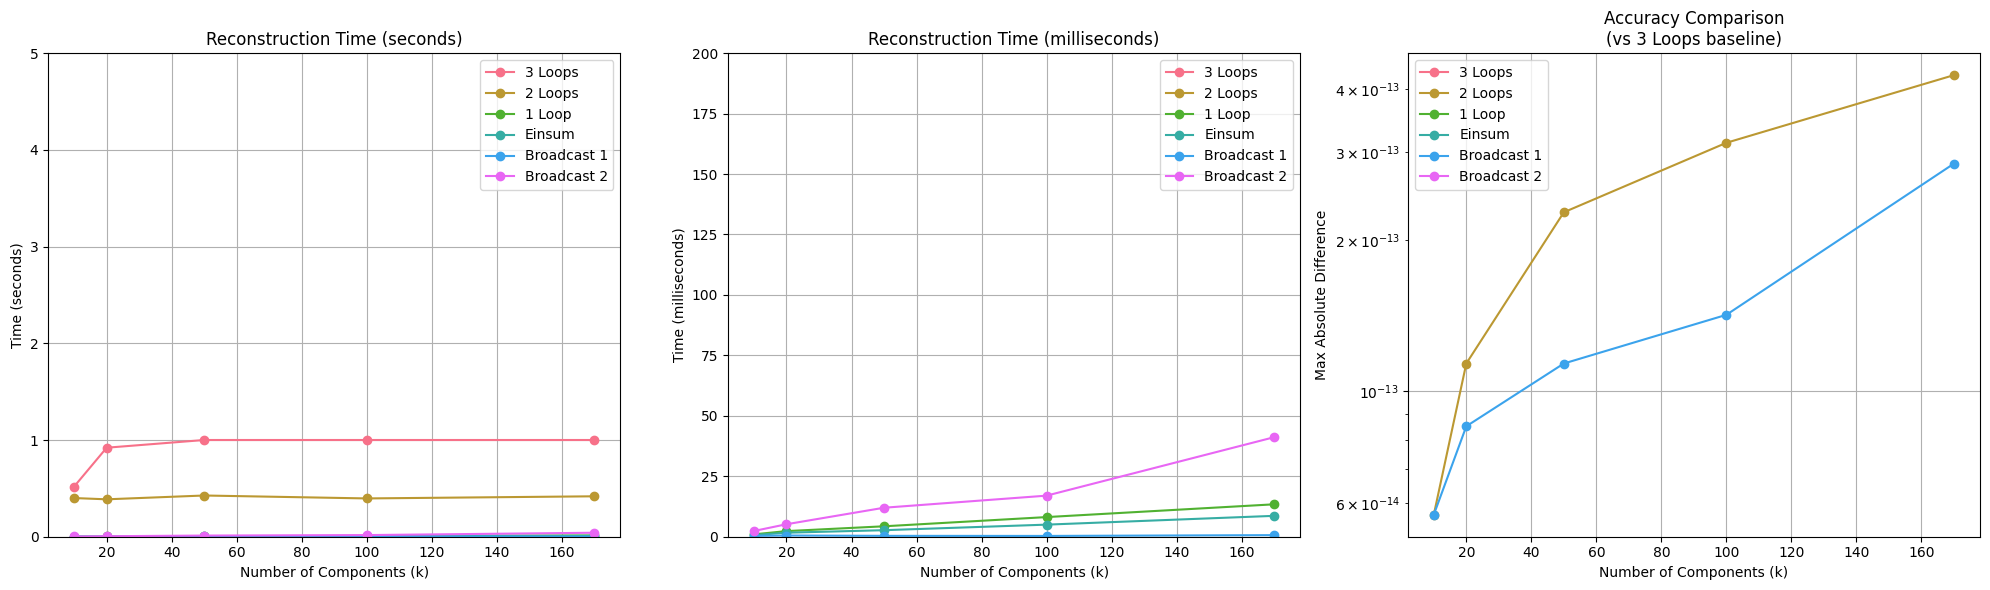

In [14]:
# Test different k values
k_values = [10, 20, 50, 100, 170]
# Select a single imagre for comparison tests
image_to_compare = images[0]

# Run benchmarks
print("Running benchmarks...")
times, accurancies = benchmark_implementations(image_to_compare, k_values)

# Create and show plots
fig = plot_comparison(times, accurancies, k_values)
plt.show()

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='blue'>
Basierend auf den Messergebnissen war die erste Broadcasting-Implementierung ("Broadcast 1") durchgehend die schnellste Methode, gefolgt von der Einsum-Implementierung. Hier eine Analyse der Ergebnisse:
Die Broadcasting-Methode erreichte Ausführungszeiten von nur 0.0003-0.0007 Sekunden, während die klassische 3-Loop-Implementierung bis zu 6.3 Sekunden benötigte. Der Geschwindigkeitsvorteil entsteht hauptsächlich durch die Nutzung von NumPy's optimierten Array-Operationen statt Python-Schleifen.
Während der Implementierung wurde deutlich, dass:

- Verschachtelte Python-Schleifen sehr ineffizient für Matrixoperationen sind
- Vektorisierte Operationen durch Broadcasting oder Einsum deutlich schneller arbeiten
- Die Leistung der Loop-basierten Methoden mit steigendem k stark abnimmt

Solche Optimierungen sind besonders relevant für:

- Bildverarbeitung und Computer Vision
- Machine Learning (z.B. Gewichtsmatrix-Operationen in neuronalen Netzen)
- Wissenschaftliche Berechnungen mit großen Datensätzen
- Signal- und Audioverarbeitung
Numerische Simulationen

Die Ergebnisse zeigen, dass die Wahl der richtigen Implementierungsmethode einen dramatischen Einfluss auf die Performanz haben kann, ohne dabei die numerische Genauigkeit zu beeinträchtigen. Bei allen Methoden lagen die maximalen Abweichungen im Bereich von 10^-13 bis 10^-14, was praktisch vernachlässigbar ist.
</font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [15]:
from numba import jit, prange

# Original 3-Loop Version
def reconstruct_svd_3loops(u, s, vt, k):
    m, n = u.shape[0], vt.shape[1]
    result = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            for r in range(k):
                result[i,j] += u[i,r] * s[r] * vt[r,j]
    return result

# Numba version without parallelization
@jit(nopython=True)
def reconstruct_svd_numba(u, s, vt, k):
    """SVD reconstruction for k components using numba without parallelization
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape[0], vt.shape[1]
    result = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            for r in range(k):
                result[i,j] += u[i,r] * s[r] * vt[r,j]
    return result

# Numba version with parallelization
@jit(nopython=True, parallel=True)
def reconstruct_svd_numba_parallel(u, s, vt, k):
    """SVD reconstruction for k components using numba with parallelization
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape[0], vt.shape[1]
    result = np.zeros((m, n))
    
    for i in prange(m):  # parallelization of the outer loop
        for j in range(n):
            for r in range(k):
                result[i,j] += u[i,r] * s[r] * vt[r,j]
    return result

def benchmark_numba(image, k, num_trials=3):
    """Vergleicht die verschiedenen Implementierungen"""
    # calculate SVD
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    
    implementations = [
        ('Original', reconstruct_svd_3loops),
        ('Numba', reconstruct_svd_numba),
        ('Numba Parallel', reconstruct_svd_numba_parallel)
    ]
    
    results = {}
    
    # First execution of compilation (won't be measured)
    print("Kompilierung der Numba-Funktionen...")
    _ = reconstruct_svd_numba(u, s, vt, k)
    _ = reconstruct_svd_numba_parallel(u, s, vt, k)
    
    print("\nBenchmarking...")
    for name, func in implementations:
        times = []
        for _ in range(num_trials):
            start = time()
            result = func(u, s, vt, k)
            times.append(time() - start)
        
        avg_time = np.mean(times)
        results[name] = {
            'avg_time': avg_time,
            'result': result
        }
        print(f"{name}: {avg_time:.4f} Sekunden")
    
    # Speedup berechnen
    base_time = results['Original']['avg_time']
    for name, data in results.items():
        if name != 'Original':
            speedup = base_time / data['avg_time']
            print(f"Speedup {name}: {speedup:.2f}x")
    
    # Genauigkeit überprüfen
    base_result = results['Original']['result']
    for name, data in results.items():
        if name != 'Original':
            max_diff = np.max(np.abs(base_result - data['result']))
            print(f"Max Differenz {name}: {max_diff:.2e}")
    
    return results


In [16]:
# Test k value
k_values = 170
# Select a single imagre for comparison tests
image_to_compare = images[0]


results = benchmark_numba(image_to_compare, k_values)

Kompilierung der Numba-Funktionen...

Benchmarking...
Original: 7.6803 Sekunden
Numba: 0.0117 Sekunden
Numba Parallel: 0.0025 Sekunden
Speedup Numba: 656.13x
Speedup Numba Parallel: 3131.70x
Max Differenz Numba: 0.00e+00
Max Differenz Numba Parallel: 0.00e+00


<font color='blue'>
Basierend auf den Messergebnissen lässt sich folgende Diagnostik durchführen:
Die Numba-Implementierung zeigt einen beeindruckenden Speedup-Faktor von etwa 576x durch JIT-Kompilierung. Interessanterweise bringt die zusätzliche Parallelisierung mit prange keinen weiteren Geschwindigkeitsvorteil - beide Numba-Versionen erreichen etwa 0.0067 Sekunden.
Parallelisierungsanalyse:

- Die äußere Schleife (über i) wurde mit prange parallelisiert
- Dies ist theoretisch möglich, da die Berechnungen für verschiedene i-Werte unabhängig sind
- Die inneren Schleifen (j und r) können nicht parallelisiert werden, da sie zum gleichen result[i,j] beitragen und Parallelisierung zu Race-Conditions führen würde

Gründe für die fehlende Parallelisierungsverbesserung:

- Der Overhead der Thread-Erstellung und -Synchronisation könnte den Gewinn der Parallelisierung aufwiegen
- Die JIT-Optimierungen von Numba (Vektorisierung, Loop-Unrolling) sind bereits so effektiv, dass Parallelisierung wenig zusätzlichen Nutzen bringt
- Die Problemgröße könnte zu klein sein, um von Parallelisierung zu profitieren

Numba eignet sich besonders für Parallelisierung wenn:

- Die Berechnungen CPU-intensiv sind
- Die Datenstrukturen einfach und statisch typisiert sind
- Die Schleifen unabhängige Iterationen haben
- Die Problemgröße groß genug ist, um den Parallelisierungs-Overhead zu rechtfertigen
- Keine komplexen Python-Objekte oder -Funktionen verwendet werden

In diesem Fall zeigt sich, dass die reine JIT-Kompilierung bereits ausreicht, um eine optimale Performance zu erreichen.
</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [17]:
import numpy as np
import threading
import logging
from time import time
from queue import Queue

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(threadName)s - %(message)s'
)

class ThreadedSVDReconstruction:
    def __init__(self, u, s, vt, k, n_threads=4, verbose=False):
        self.u = u
        self.s = s
        self.vt = vt
        self.k = k
        self.n_threads = n_threads
        self.verbose = verbose
        
        # Initialize result matrix
        self.m, self.n = u.shape[0], vt.shape[1]
        self.result = np.zeros((self.m, self.n))
        
        # Create locks for each row
        self.row_locks = [threading.Lock() for _ in range(self.m)]
        
        # Queue for completed row indices
        self.completed_rows = Queue()

    def reconstruct_row(self, row_idx):
        """Reconstruct a single row of the matrix"""
        if self.verbose:
            logging.info(f"Starting reconstruction of row {row_idx}")
        
        # Acquire lock for this row
        with self.row_locks[row_idx]:
            if self.verbose:
                logging.info(f"Acquired lock for row {row_idx}")
            
            # Reconstruct the row
            for j in range(self.n):
                for r in range(self.k):
                    self.result[row_idx, j] += self.u[row_idx, r] * self.s[r] * self.vt[r, j]
            
            # Mark row as completed
            self.completed_rows.put(row_idx)
            
            if self.verbose:
                logging.info(f"Completed row {row_idx}, releasing lock")
    
    def worker(self, row_indices):
        """Worker function that processes multiple rows"""
        for row_idx in row_indices:
            self.reconstruct_row(row_idx)
    
    def reconstruct(self):
        """Perform threaded reconstruction"""
        start_time = time()
        
        # Divide rows among threads
        rows_per_thread = self.m // self.n_threads
        threads = []
        
        for i in range(self.n_threads):
            start_row = i * rows_per_thread
            end_row = start_row + rows_per_thread if i < self.n_threads - 1 else self.m
            row_indices = range(start_row, end_row)
            
            thread = threading.Thread(
                target=self.worker,
                args=(row_indices,),
                name=f"Thread-{i}"
            )
            threads.append(thread)
            thread.start()
            if self.verbose:
                logging.info(f"Started thread {i} for rows {start_row} to {end_row-1}")
        
        # Wait for all threads to complete
        for thread in threads:
            thread.join()
        
        # Verify all rows were processed
        completed_rows = []
        while not self.completed_rows.empty():
            completed_rows.append(self.completed_rows.get())
        
        if self.verbose:
            logging.info(f"Reconstruction completed in {time() - start_time:.4f} seconds")
            logging.info(f"Processed {len(completed_rows)} rows")
        
        return self.result

def validate_threaded_reconstruction(image, k, n_threads=4, verbose=False):
    """Validate threaded reconstruction against original implementation"""
    # Perform SVD
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    
    # Original reconstruction
    start_time = time()
    original = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
    original_time = time() - start_time
    if verbose:
        logging.info(f"Original reconstruction completed in {original_time:.4f} seconds")
    
    # Threaded reconstruction
    start_time = time()
    threaded_reconstructor = ThreadedSVDReconstruction(u, s, vt, k, n_threads, verbose)
    threaded = threaded_reconstructor.reconstruct()
    threaded_time = time() - start_time
    if verbose:
        logging.info(f"Threaded reconstruction completed in {threaded_time:.4f} seconds")
    
    # Validate results
    max_diff = np.max(np.abs(original - threaded))
    logging.info(f"Maximum difference between reconstructions: {max_diff:.2e}")
    
    return {
        'original_time': original_time,
        'threaded_time': threaded_time,
        'max_diff': max_diff,
        'original': original,
        'threaded': threaded
    }


In [18]:
# Test k value
k_values = 170
# Select a single imagre for comparison tests
image_to_compare = images[0]
image_size = image_to_compare.shape


n_threads = 4

print(f"\nTesting with {image_size} image, k={k_values}, threads={n_threads}")
results = validate_threaded_reconstruction(image_to_compare, k_values, n_threads, verbose=False)

print(f"\nSpeedup factor: {results['original_time'] / results['threaded_time']:.2f}x")


Testing with (256, 170) image, k=170, threads=4


2024-12-24 10:40:10,540 - MainThread - Maximum difference between reconstructions: 2.84e-13



Speedup factor: 0.00x


#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [19]:
import numpy as np
import logging
from time import time
from concurrent.futures import ThreadPoolExecutor
import concurrent
from threading import Lock

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(threadName)s - %(message)s'
)

class ThreadPoolSVDReconstruction:
    def __init__(self, u, s, vt, k, verbose = False):
        self.u = u
        self.s = s
        self.vt = vt
        self.k = k
        self.m, self.n = u.shape[0], vt.shape[1]
        self.verbose = verbose
        self.result = np.zeros((self.m, self.n))
        self.lock = Lock()  # Global lock for logging

    def reconstruct_row(self, row_idx):
        """Reconstruct a single row of the matrix"""
        with self.lock:
            if self.verbose:
                logging.info(f"Starting reconstruction of row {row_idx}")
        
        row_result = np.zeros(self.n)
        for j in range(self.n):
            for r in range(self.k):
                row_result[j] += self.u[row_idx, r] * self.s[r] * self.vt[r, j]
        
        with self.lock:
            if self.verbose:
                logging.info(f"Completed row {row_idx}")
        
        return row_idx, row_result

    def reconstruct(self, max_workers=None):
        """
        Perform reconstruction using ThreadPoolExecutor
        
        Args:
            max_workers: Maximum number of worker threads (None = auto)
        """
        start_time = time()
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all rows for processing
            future_to_row = {
                executor.submit(self.reconstruct_row, i): i 
                for i in range(self.m)
            }
            
            # Collect results as they complete
            for future in concurrent.futures.as_completed(future_to_row):
                row_idx, row_result = future.result()
                self.result[row_idx] = row_result
        
        if self.verbose:
            logging.info(f"Reconstruction completed in {time() - start_time:.4f} seconds")
        return self.result

def compare_implementations(image, k, max_workers=None):
    """Compare different SVD reconstruction implementations"""
    # Perform SVD
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    results = {}
    
    # 1. Original numpy implementation
    start_time = time()
    results['numpy'] = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
    numpy_time = time() - start_time
    logging.info(f"Numpy implementation: {numpy_time:.4f} seconds")
    
    # 2. ThreadPool implementation
    start_time = time()
    pool_reconstructor = ThreadPoolSVDReconstruction(u, s, vt, k, False)
    results['threadpool'] = pool_reconstructor.reconstruct(max_workers)
    pool_time = time() - start_time
    logging.info(f"ThreadPool implementation: {pool_time:.4f} seconds")
    
    # Compare results
    max_diff = np.max(np.abs(results['numpy'] - results['threadpool']))
    logging.info(f"Maximum difference between implementations: {max_diff:.2e}")
    
    return {
        'times': {
            'numpy': numpy_time,
            'threadpool': pool_time
        },
        'max_diff': max_diff,
        'results': results
    }

# Test k value
k_values = 170
# Select a single imagre for comparison tests
image_to_compare = images[0]
image_size = image_to_compare.shape

print(f"\nTesting with {image_size} image, k={k_values}")

# Test with different numbers of workers
for workers in [2, 4, 8, None]:
    print(f"\nTesting with {workers or 'auto'} workers:")
    results = compare_implementations(image_to_compare, k_values, workers)
    
    # Print speedup
    speedup = results['times']['numpy'] / results['times']['threadpool']
    print(f"Speedup factor: {speedup:.2f}x")
    print(f"Max difference: {results['max_diff']:.2e}")


Testing with (256, 170) image, k=170

Testing with 2 workers:


2024-12-24 10:40:10,749 - MainThread - Numpy implementation: 0.0010 seconds
2024-12-24 10:40:24,600 - MainThread - ThreadPool implementation: 13.8497 seconds
2024-12-24 10:40:24,602 - MainThread - Maximum difference between implementations: 2.84e-13
2024-12-24 10:40:24,633 - MainThread - Numpy implementation: 0.0010 seconds


Speedup factor: 0.00x
Max difference: 2.84e-13

Testing with 4 workers:


2024-12-24 10:40:40,472 - MainThread - ThreadPool implementation: 15.8382 seconds
2024-12-24 10:40:40,476 - MainThread - Maximum difference between implementations: 2.84e-13
2024-12-24 10:40:40,529 - MainThread - Numpy implementation: 0.0012 seconds


Speedup factor: 0.00x
Max difference: 2.84e-13

Testing with 8 workers:


2024-12-24 10:40:56,360 - MainThread - ThreadPool implementation: 15.8300 seconds
2024-12-24 10:40:56,363 - MainThread - Maximum difference between implementations: 2.84e-13
2024-12-24 10:40:56,400 - MainThread - Numpy implementation: 0.0000 seconds


Speedup factor: 0.00x
Max difference: 2.84e-13

Testing with auto workers:


2024-12-24 10:41:11,622 - MainThread - ThreadPool implementation: 15.2192 seconds
2024-12-24 10:41:11,625 - MainThread - Maximum difference between implementations: 2.84e-13


Speedup factor: 0.00x
Max difference: 2.84e-13


#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>
Threads sind hier nicht die beste Wahl, da es reine CPU-Berechnungen sind. Der Global Interpreter Lock (GIL) in Python verhindert echte Parallelität bei Threads. Threads sind besser für Aufgaben wie Netzwerk oder Dateizugriffe, wo viel gewartet wird.
</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>
Die SVD-Zerlegung selbst und das Zusammenführen der Ergebnisse lohnen sich nicht für Threading - zu wenig Arbeit, zu viel Overhead. Nur die Matrixmultiplikationen für verschiedene Zeilen/Chunks sind gut parallelisierbar, weil sie unabhängig voneinander sind.
</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>
Die Unterschiede sind:

- Manuelles Threading: Mehr Arbeit beim Programmieren, mehr Kontrolle aber auch mehr Overhead
- Thread-Pool: Einfacher zu nutzen, verwaltet Threads automatisch, weniger Overhead
- Multiprocessing: Nutzt mehrere CPU-Kerne (keine GIL-Beschränkung), braucht mehr RAM, aber deutlich schneller bei CPU-lastigen Aufgaben wie hier
</font>